# Project 3: House Price Prediction (Regression) 🏠

**Project Objective:** To build a regression model that accurately predicts the sale price of houses based on a large number of features. This project will cover the complete machine learning workflow, from deep EDA to advanced preprocessing, feature engineering, model training, and evaluation.


### Core Concepts We'll Cover:
1.  **Regression vs. Classification:** Understanding the goal of predicting a continuous value.
2.  **Target Variable Analysis:** Analyzing the distribution of `SalePrice` and applying transformations (log transform).
3.  **Advanced Data Preprocessing:** Implementing robust strategies for handling missing values in both numerical and categorical features.
4.  **Feature Engineering:** Creating new, powerful features from the existing data to improve model performance.
5.  **Categorical Encoding:** Differentiating between and applying Label Encoding and One-Hot Encoding.
6.  **Model Building:** Training and comparing a simple baseline model (Linear Regression) with an advanced model (XGBoost).
7.  **Model Evaluation:** Understanding and using key regression metrics (RMSE, MAE, R-squared).

### Step 1: Setup - Importing Libraries and Kaggle API

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import xgboost as xgb
import os

sns.set_style('darkgrid')

### Step 2: Data Loading via Kaggle API
We will load the data directly from the Kaggle competition. This is the standard and most reliable method for using Kaggle datasets in a cloud environment like Colab.

**Instructions:**
1.  Go to your Kaggle account page ([https://www.kaggle.com/account](https://www.kaggle.com/account)) and click **'Create New Token'** in the API section. This will download a `kaggle.json` file.
2.  Run the code cell below. It will prompt you to upload a file. Select the `kaggle.json` file you just downloaded.

In [3]:
# Install the Kaggle library
!pip install -q kaggle

# Use Colab's file uploader
from google.colab import files
print("Please upload the kaggle.json file you downloaded from your Kaggle account.")
files.upload()

# Create a directory for the Kaggle API configuration
!mkdir -p ~/.kaggle
# Move the uploaded kaggle.json to the required directory
!cp kaggle.json ~/.kaggle/
# Set the correct permissions for the file
!chmod 600 ~/.kaggle/kaggle.json

print("\nKaggle API configured successfully.")

Please upload the kaggle.json file you downloaded from your Kaggle account.


Saving kaggle.json to kaggle.json

Kaggle API configured successfully.


In [4]:
# Download the dataset from the 'house-prices-advanced-regression-techniques' competition
!kaggle competitions download -c house-prices-advanced-regression-techniques

# Unzip the downloaded files
!unzip -o house-prices-advanced-regression-techniques.zip

print("\nDataset downloaded and unzipped.")

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 655MB/s]
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               

Dataset downloaded and unzipped.


In [5]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

In [6]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
train_df.set_index('Id', inplace=True)
test_df.set_index('Id', inplace=True)

In [8]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Step 3: Deep Dive EDA on the Target Variable (`SalePrice`)
The most important variable in our dataset is the one we want to predict. Understanding its characteristics is the first and most critical step in any regression problem.

In [9]:
train_df['SalePrice'].skew()

np.float64(1.8828757597682129)

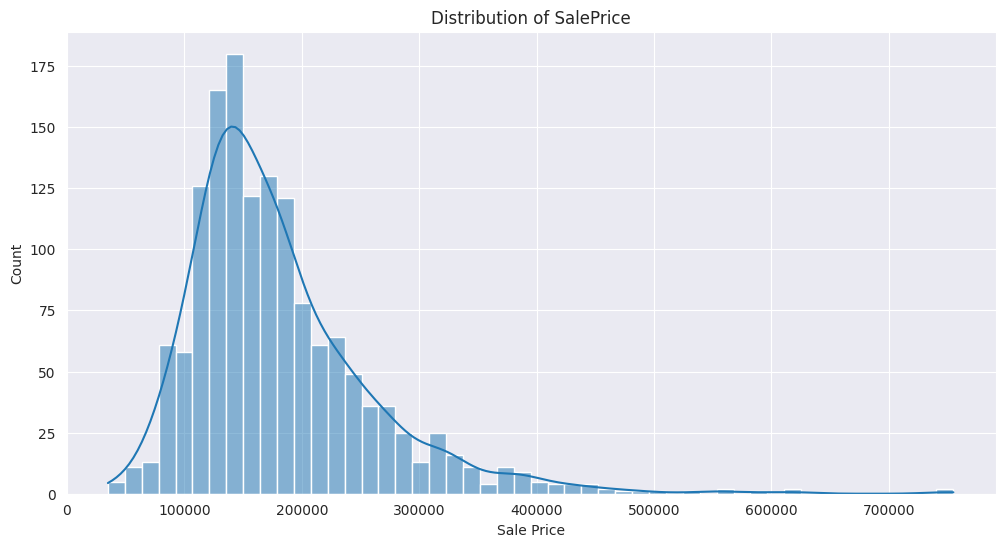

Skewness of SalePrice: 1.8828757597682129


In [10]:
plt.figure(figsize=(12, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins=50)
plt.title('Distribution of SalePrice')
plt.xlabel('Sale Price')
plt.show()

print(f"Skewness of SalePrice: {train_df['SalePrice'].skew()}")

#### **Theoretical Concept: Skewness and Log Transformation**
The distribution of `SalePrice` is **positively skewed** (or right-skewed). This means there's a long tail of very expensive houses, which can negatively impact the performance of some models, especially linear models like Linear Regression. These models often assume that the variables (and especially the residuals of the model) are normally distributed.

To fix this, we can apply a **log transformation** (`np.log1p`, which is `log(1+x)` to handle potential zero values). This transformation compresses the range of large values, making the distribution more symmetrical and closer to a normal distribution.

In [11]:
print(np.log(10))
print(np.log(1000))
print(np.log(100000))
print(np.log(10000000))
print(np.log(1000000000))
print(np.log(10000000000))

2.302585092994046
6.907755278982137
11.512925464970229
16.11809565095832
20.72326583694641
23.025850929940457


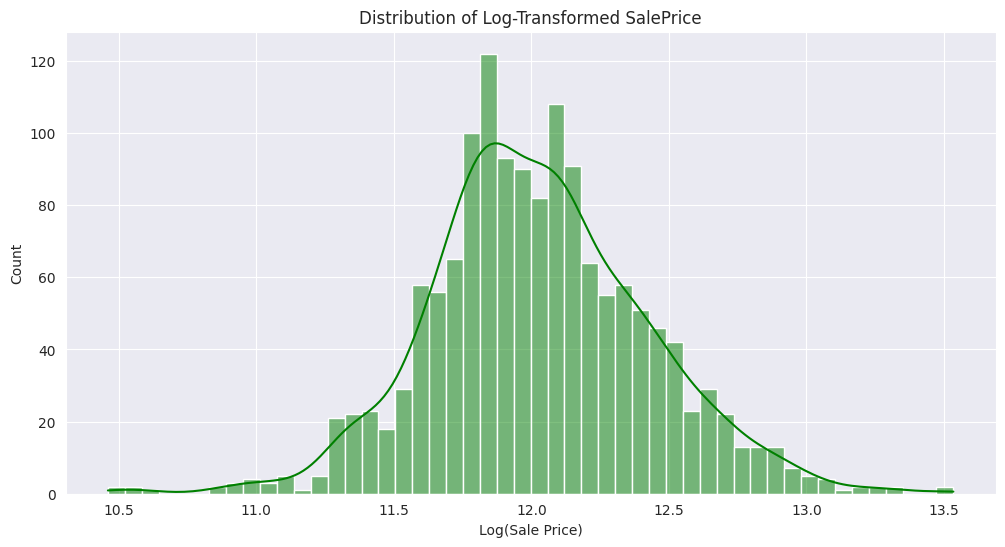

Skewness of Log-Transformed SalePrice: 0.12134661989685333


In [12]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

plt.figure(figsize=(12, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins=50, color='green')
plt.title('Distribution of Log-Transformed SalePrice')
plt.xlabel('Log(Sale Price)')
plt.show()

print(f"Skewness of Log-Transformed SalePrice: {train_df['SalePrice'].skew()}")

### Step 4: EDA on Feature Variables

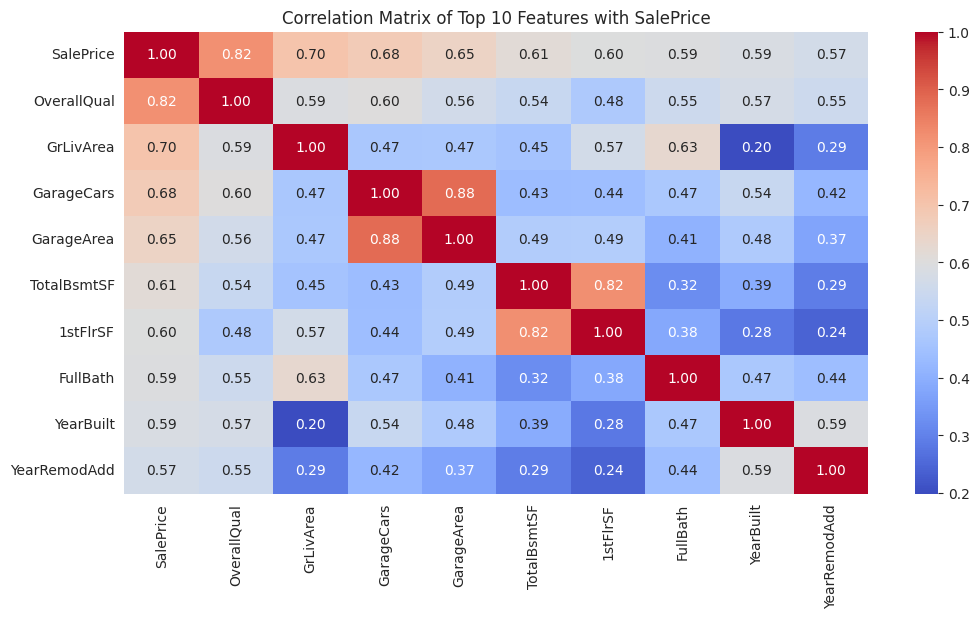

In [13]:
corrmat = train_df.corr(numeric_only=True)
top_corr_features = corrmat.nlargest(10,'SalePrice')['SalePrice'].index
top_corr_matrix = train_df[top_corr_features].corr()

plt.figure(figsize=(12,6))
sns.heatmap(top_corr_matrix,annot=True,cmap='coolwarm',fmt='.2f')
plt.title('Correlation Matrix of Top 10 Features with SalePrice')
plt.show()

**Insight:** The heatmap shows that `OverallQual` (Overall Quality), `GrLivArea` (Above Ground Living Area), and `GarageCars`/`GarageArea` are the most positively correlated features with `SalePrice`. This makes intuitive sense—better quality, larger houses with bigger garages tend to be more expensive.

### Step 5: Data Preprocessing & Feature Engineering
This is the most intensive part of the project. We will handle missing values, create new features, and encode categorical variables to prepare the data for modeling.

In [14]:
train_df.shape

(1460, 80)

In [15]:
test_df.shape

(1459, 79)

In [16]:
# Combine train and test data for consistent preprocessing
all_data = pd.concat((train_df.loc[:,:'SaleCondition'],
                      test_df.loc[:,:'SaleCondition']))

print(f"Combined data shape: {all_data.shape}")

Combined data shape: (2919, 79)


#### 5.1 Handling Missing Values

In [17]:
missing_data = all_data.isnull().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data > 0]

print(missing_data)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Functional         2
BsmtFullBath       2
Utilities          2
Exterior1st        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF1         1
SaleType           1
KitchenQual        1
GarageCars         1
GarageArea         1
Electrical         1
Exterior2nd        1
BsmtFinSF2         1
dtype: int64


In [18]:
# Impute numerical features with 0
numerical_cols_to_impute_zero = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'BsmtFullBath', 'BsmtHalfBath']
for col in numerical_cols_to_impute_zero:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(0)

In [19]:
all_data[numerical_cols_to_impute_zero].isna().sum()

,0
MasVnrArea,0
BsmtFinSF1,0
BsmtFinSF2,0
BsmtUnfSF,0
TotalBsmtSF,0
GarageCars,0
GarageArea,0
BsmtFullBath,0
BsmtHalfBath,0


In [20]:
all_data['Neighborhood'].value_counts()

,count
Neighborhood,
NAmes,443
CollgCr,267
OldTown,239
Edwards,194
Somerst,182
NridgHt,166
Gilbert,165
Sawyer,151
NWAmes,131


In [21]:
all_data['LotFrontage'].value_counts()

,count
LotFrontage,
60.0,276
80.0,137
70.0,133
50.0,117
75.0,105
...,...
155.0,1
126.0,1
200.0,1


In [22]:
# Impute LotFrontage with the median of the neighborhood
if 'LotFrontage' in all_data.columns and all_data['LotFrontage'].isna().any():
    all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [23]:
all_data['Alley'].value_counts()

,count
Alley,
Grvl,120
Pave,78


In [24]:
# Impute categorical features with 'None' (for features where NA means 'no') or mode (for features where NA means missing data)
categorical_cols_to_impute_none = ['Alley', 'Fence', 'MiscFeature', 'PoolQC', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
for col in categorical_cols_to_impute_none:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna('None')

In [25]:
for col in ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Utilities', 'Functional', 'MSZoning']:
    if col in all_data.columns: # Check if column exists after one-hot encoding
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [26]:
all_data['GarageYrBlt'].value_counts()

,count
GarageYrBlt,
2005.0,142
2006.0,115
2007.0,115
2004.0,99
2003.0,92
...,...
1896.0,1
1895.0,1
2207.0,1


In [27]:
all_data.isnull().sum().sum()

np.int64(159)

In [28]:
# Based on the likely remaining missing values (GarageYrBlt), impute the remaining numerical features.
# GarageYrBlt can be imputed with 0 (assuming 0 means no garage, consistent with GarageArea/Cars=0)
if 'GarageYrBlt' in all_data.columns:
    all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(0)


print("\nMissing values after all imputation:", all_data.isna().sum().sum())


Missing values after all imputation: 0


#### 5.2 Feature Engineering

In [29]:
# Create a total square footage feature
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [30]:
# Create a total bathrooms feature
all_data['TotalBath'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                         all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

In [31]:
# Create a feature for age of the house at sale
all_data['Age'] = all_data['YrSold'] - all_data['YearBuilt']

#### 5.3 Categorical Encoding

#### **Theoretical Concept: Ordinal vs. Nominal Features**
To use categorical features in a model, we must convert them to numbers. The method depends on the type of feature:
1.  **Ordinal Features:** These have an inherent order (e.g., `Poor < Fair < Good < Excellent`). For these, we use **Label Encoding**, which assigns an integer to each category based on its order (e.g., `Poor=0, Fair=1, ...`).
2.  **Nominal Features:** These have no inherent order (e.g., `Neighborhood`). Using Label Encoding would imply a false order. Instead, we use **One-Hot Encoding**, which creates a new binary (0/1) column for each category.

In [32]:
categorical_cols = all_data.select_dtypes(include=['object']).columns

In [33]:
all_data = pd.get_dummies(all_data,columns=categorical_cols,drop_first=True)

### Step 6: Model Building & Training

In [34]:
# Separate the preprocessed data back into training and testing sets
X = all_data[:len(train_df)]
y = train_df['SalePrice']
X_test_final = all_data[len(train_df):]

In [35]:
# Split the training data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
y_val

,SalePrice
Id,
893,11.947956
1106,12.691584
414,11.652696
523,11.976666
1037,12.661917
...,...
480,11.401681
1362,12.468441
803,12.149508


#### **Theoretical Concept: Feature Scaling**
Many models, especially linear models and distance-based algorithms, perform better when numerical features are on a similar scale. **Standardization** (`StandardScaler`) is a common technique that transforms the data to have a mean of 0 and a standard deviation of 1. This prevents features with large scales (like `GrLivArea`) from dominating features with small scales (like `OverallQual`).

In [40]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [41]:
X_train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
255,20,70.0,8400,5,6,1957,1957,0.0,922.0,0.0,...,False,False,False,False,True,False,False,False,True,False
1067,60,59.0,7837,6,7,1993,1994,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False
639,30,67.0,8777,5,7,1910,1950,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False
800,50,60.0,7200,5,7,1937,1950,252.0,569.0,0.0,...,False,False,False,False,True,False,False,False,True,False
381,50,50.0,5000,5,6,1924,1950,0.0,218.0,0.0,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,20,78.0,9317,6,5,2006,2006,0.0,24.0,0.0,...,False,False,False,False,True,False,False,False,True,False
1131,50,65.0,7804,4,3,1928,1950,0.0,622.0,0.0,...,False,False,False,False,True,False,False,False,True,False
1295,20,60.0,8172,5,7,1955,1990,0.0,167.0,0.0,...,False,False,False,False,True,False,False,False,True,False


In [42]:
X_train_scaled

array([[-0.8667643 , -0.01933867, -0.21289571, ..., -0.12510865,
         0.46001984, -0.30263639],
       [ 0.07410996, -0.50039047, -0.26524463, ..., -0.12510865,
         0.46001984, -0.30263639],
       [-0.63154574, -0.15053462, -0.17784146, ..., -0.12510865,
         0.46001984, -0.30263639],
       ...,
       [-0.8667643 , -0.45665849, -0.23409563, ..., -0.12510865,
         0.46001984, -0.30263639],
       [-0.16110861, -0.6753184 , -0.28337613, ..., -0.12510865,
         0.46001984, -0.30263639],
       [ 1.48542135, -0.76278236, -0.65139925, ..., -0.12510865,
         0.46001984, -0.30263639]])

In [43]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_final_scaled = scaler.transform(X_test_final)

## **Theoretical Concept: Linear Regression**
Linear Regression is a fundamental supervised learning algorithm used for predicting a continuous target variable based on one or more input features. It assumes a linear relationship between the features (independent variables) and the target variable (dependent variable).

The goal of Linear Regression is to find the best-fitting straight line (or hyperplane in higher dimensions) that minimizes the sum of the squared differences between the observed and predicted values. This is known as the Ordinary Least Squares (OLS) method.

The equation for simple linear regression (one feature) is:
$$y = \beta_0 + \beta_1x + \epsilon$$
Where:
- $y$ is the target variable (SalePrice in our case)
- $x$ is the input feature
- $\beta_0$ is the y-intercept
- $\beta_1$ is the coefficient for the feature $x$ (representing the change in $y$ for a one-unit change in $x$)
- $\epsilon$ is the error term

For multiple linear regression (multiple features), the equation is:
$$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n + \epsilon$$
Where $x_1, x_2, ..., x_n$ are the input features and $\beta_1, \beta_2, ..., \beta_n$ are their respective coefficients.

**Assumptions of Linear Regression:**
1. **Linearity:** The relationship between the features and the target variable is linear.
2. **Independence:** The observations are independent of each other.
3. **Homoscedasticity:** The variance of the errors is constant across all levels of the features.
4. **Normality:** The errors are normally distributed.
5. **No Multicollinearity:** The features are not highly correlated with each other.

While Linear Regression is simple and interpretable, it can be sensitive to outliers and may not perform well if the assumptions are violated or if the relationships are highly non-linear.

#### 6.1 Model 1: Linear Regression (Baseline)

In [44]:
lr = LinearRegression()
lr.fit(X_train_scaled,y_train)
y_pred_lr = lr.predict(X_val_scaled)

### **Theoretical Concept: XGBoost (Extreme Gradient Boosting)**
XGBoost is a highly efficient and popular gradient boosting algorithm. It's an optimized distributed gradient boosting library designed to be highly flexible, portable, and efficient.

**How it works:**
XGBoost builds trees sequentially. Each new tree attempts to correct the errors made by the previous trees. The predictions from all the trees are then summed up to get the final prediction.

**Key Features and Advantages:**
1. **Regularization:** Includes L1 and L2 regularization to prevent overfitting.
2. **Handling Missing Values:** Has a built-in mechanism to handle missing values.
3. **Tree Pruning:** Supports 'depth-first' and 'breadth-first' tree growth and pruning, which can improve performance and reduce overfitting.
4. **Parallel Processing:** Designed to be highly parallelizable, making it faster than traditional gradient boosting implementations.
5. **Flexibility:** Supports various objective functions and evaluation metrics.

XGBoost is known for its performance on structured data and is often a top choice in machine learning competitions. However, it can be more complex to tune and understand compared to simpler models like Linear Regression.

In [45]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror', # Corrected objective function
                        n_estimators=10000,
                        learning_rate=0.05,
                        max_depth=3,
                        min_child_weight=1,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        random_state=42)

# XGBoost can handle NaNs, but since we've cleaned the data, we can use the scaled data as well if preferred.
# However, XGBoost generally doesn't require scaling. We'll use the unscaled data as it's a tree-based model.
xgbr.fit(X_train, y_train)
y_pred_xgb = xgbr.predict(X_val)

### Step 7: Model Evaluation

#### **Theoretical Concept: Regression Metrics**
- **Mean Absolute Error (MAE):** The average absolute difference between the predicted and actual values. It's easy to interpret.
- **Mean Squared Error (MSE):** The average of the squared differences. It penalizes larger errors more heavily.
- **Root Mean Squared Error (RMSE):** The square root of MSE. It's the most common metric because it's in the same units as the target variable (in our case, log-price), making it more interpretable than MSE.
- **R-squared ($R^2$):** The proportion of the variance in the target variable that is predictable from the features. A value closer to 1 indicates a better fit.

In [46]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} Performance ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R-squared: {r2:.4f}\n")

# evaluate_model(y_val, y_pred_lr, "Linear Regression") # Commenting out Linear Regression evaluation as it failed
evaluate_model(y_val,y_pred_lr,'Linear Regression')
evaluate_model(y_val, y_pred_xgb, "XGBoost")

--- Linear Regression Performance ---
RMSE: 0.1734
MAE:  0.0960
R-squared: 0.8389

--- XGBoost Performance ---
RMSE: 0.1324
MAE:  0.0859
R-squared: 0.9060



### Step 8: Create Submission File

In [47]:
# Make predictions on the final test set using the best model (XGBoost)
# Use the unscaled test data for XGBoost prediction
final_predictions_log = xgbr.predict(X_test_final)

# IMPORTANT: We must reverse the log transformation to get the predictions back on the original price scale
final_predictions = np.expm1(final_predictions_log)

# Create the submission DataFrame
submission = pd.DataFrame({'Id': test_df.index, 'SalePrice': final_predictions})

# Save to csv
submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully.")
submission.head()

Submission file 'submission.csv' created successfully.


,Id,SalePrice
0,1461,124708.789062
1,1462,164473.437500
2,1463,189848.312500
3,1464,196051.765625
4,1465,181740.234375


### Step 9: Conclusion

In this project, we successfully built an end-to-end regression pipeline to predict house prices.

**Key Steps Undertaken:**
1.  **Analyzed and transformed the target variable** (`SalePrice`) to handle its skewness.
2.  Conducted a **thorough EDA** to understand the key features influencing price.
3.  Implemented a **robust preprocessing strategy**, handling various types of missing data and encoding categorical features correctly.
4.  **Engineered new features** (`TotalSF`, `TotalBath`, `Age`) that provided more predictive power.
5.  **Trained and compared two models**, demonstrating the superior performance of XGBoost over a simple linear model.
6.  **Evaluated the models** using standard regression metrics and generated a final submission file.

**Potential Next Steps:**
- **Hyperparameter Tuning:** Use techniques like GridSearchCV to find the optimal parameters for the XGBoost model.
- **More Feature Engineering:** Create more complex features, such as interaction terms between key variables.
- **Ensemble Modeling:** Combine the predictions of several different models to potentially achieve even better results.